# Elastic Full Proc2D Means

In [41]:
detach("package:elasdics2d", unload=TRUE)
devtools::install("../../elasdics")
library(elasdics2d)
library(ggplot2)
library(gridExtra)
library(dplyr)


v  checking for file 'D:\Dropbox\Statistik\elasdics/DESCRIPTION' (355ms)
-  preparing 'elasdics2d': (475ms)
v  checking DESCRIPTION meta-information
-  checking for LF line-endings in source and make files and shell scripts
-  checking for empty or unneeded directories
-  building 'elasdics2d_0.1.0.tar.gz'
   
Running "C:/Users/Manuel/ANACON~1/envs/rstudio/lib/R/bin/x64/Rcmd.exe" \
  INSTALL \
  "C:\Users\Manuel\AppData\Local\Temp\RtmpGEg1ZI/elasdics2d_0.1.0.tar.gz" \
  --install-tests 
* installing to library 'C:/Users/Manuel/Anaconda3/envs/rstudio/lib/R/library'
* installing *source* package 'elasdics2d' ...
** using staged installation
** R
** tests
** byte-compile and prepare package for lazy loading
No man pages found in package ** help
 'elasdics2d' 
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a 


Attaching package: 'elasdics2d'


The following object is masked _by_ '.GlobalEnv':

    center_curve




ProcrustesLoad some datasets with random rotation and scaling.

In [42]:
source("../scripts/load_datasets.R")
set.seed(18)

data_curves <- curves.spiral(n_curves=20, rotate=TRUE, scale=TRUE, center=TRUE)
data_curves2 <- curves.digit3(rotate=TRUE, scale=TRUE, center=TRUE)

Take a look at the data curves.

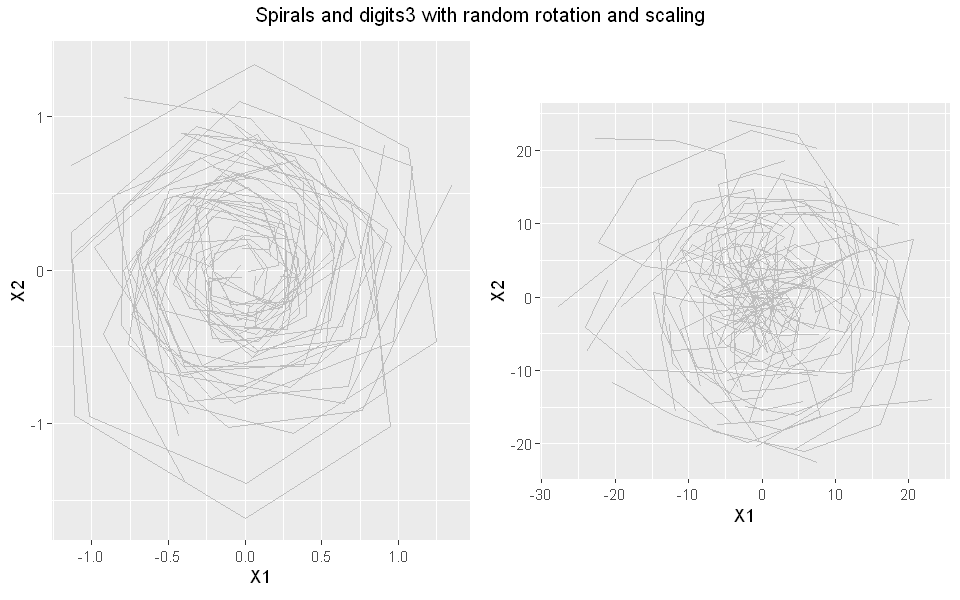

In [43]:
p1 <- ggplot(bind_rows(data_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

p2 <- ggplot(bind_rows(data_curves2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

# Display plots in smaller size
options(repr.plot.width=8, repr.plot.height=5)

grid.arrange(p1, p2, nrow=1, top="Spirals and digits3 with random rotation and scaling")

#### Calculate Smooth Elastic Mean

In [48]:
# Turn of warnings
defaultW <- getOption("warn")
options(warn = -1)

# Compute Means
knots <- seq(0,1, length = 11)
smooth_elastic_mean <- compute_elastic_mean(data_curves, knots = knots, type = "smooth", proc2d = TRUE)
knots2 <- seq(0,1, length = 13)
smooth_elastic_mean2 <- compute_elastic_mean(data_curves2, knots = knots2, type = "smooth", proc2d = TRUE)

# Turn on warnings
options(warn = defaultW)

#### Plot Mean and Procrustes fits from Data curves via G,b

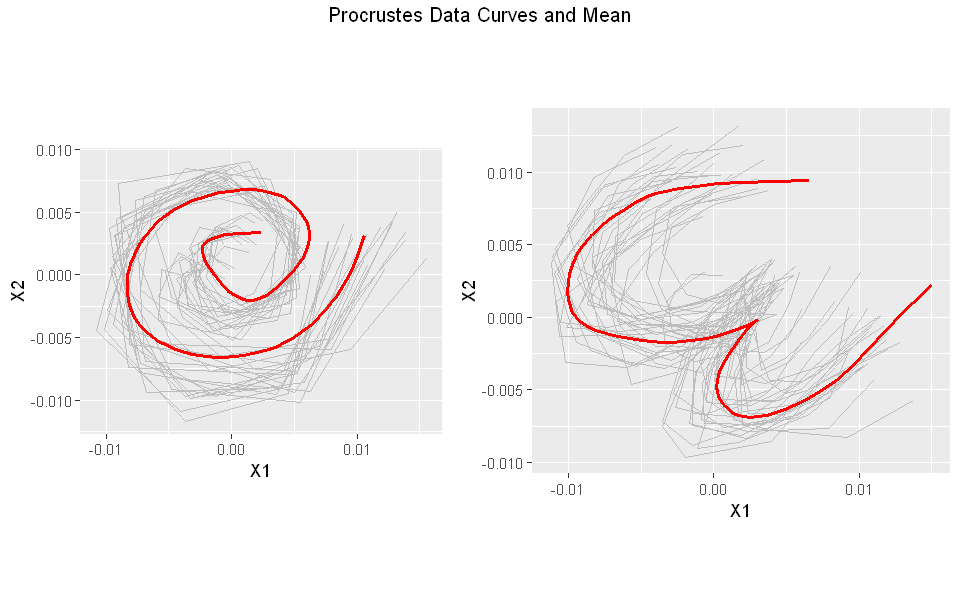

In [49]:
pfits <- lapply(seq_along(data_curves), function(j){
    get_proc2d_from_param(
        data_curves[[j]],
        smooth_elastic_mean$G_optims[[j]],
        smooth_elastic_mean$b_optims[[j]]
    )
})

pfits2 <- lapply(seq_along(data_curves2), function(j){
    get_proc2d_from_param(
        data_curves2[[j]],
        smooth_elastic_mean2$G_optims[[j]],
        smooth_elastic_mean2$b_optims[[j]]
    )
})

p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=-X2), color = "red", size = 1) +
    coord_fixed()

p2 <- ggplot(bind_rows(pfits2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=-X2), color = "red", size = 1) +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, widths=8:9, top="Procrustes Data Curves and Mean")

#### Elastic mean on Procrustes Fits

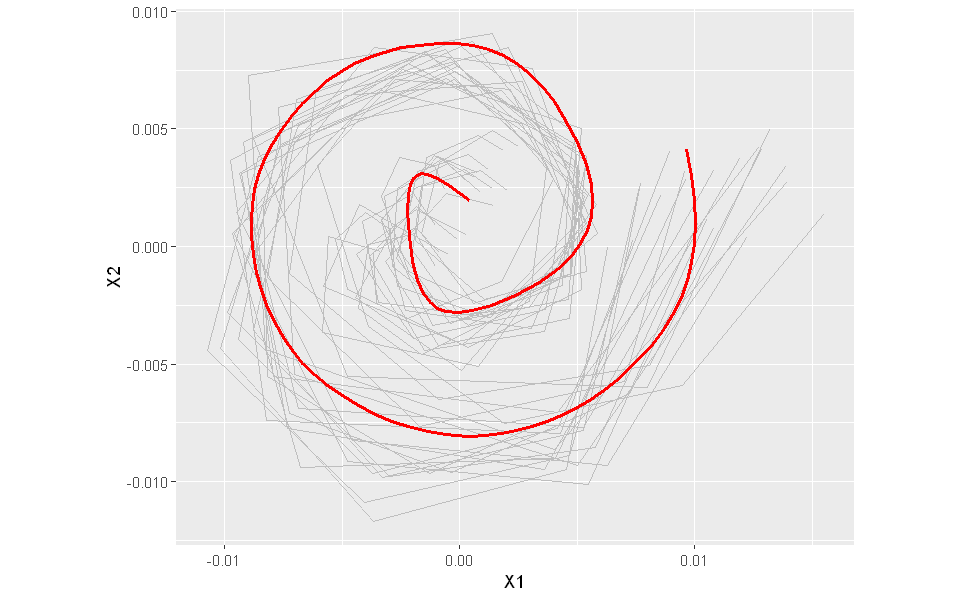

In [50]:
mean3 <- compute_elastic_mean(pfits, knots = knots, type = "smooth")

ggplot(bind_rows(mean3$data_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(mean3), aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()

#### Plot Mean and Procrustes Fits from SRV curves

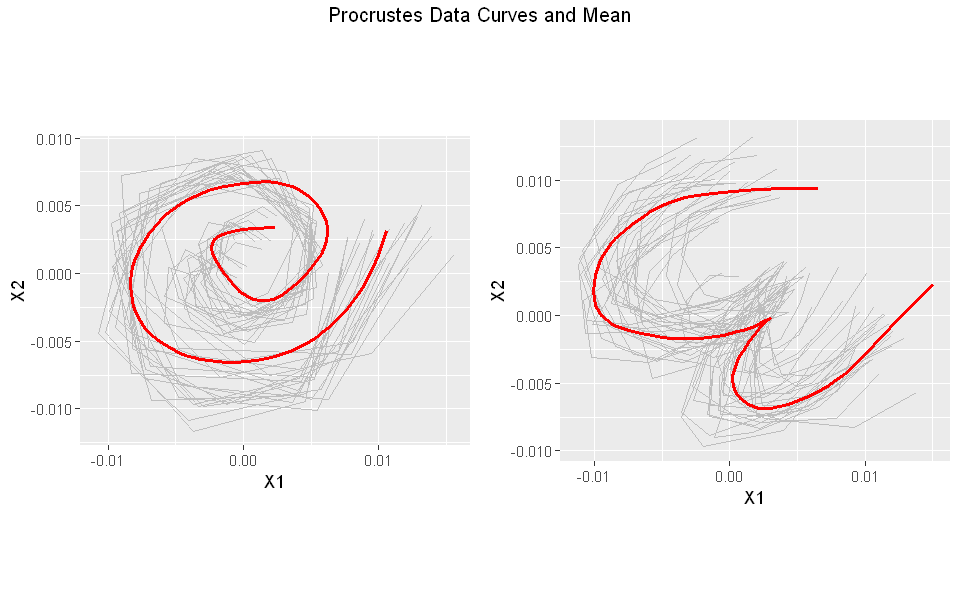

In [51]:
p1 <- ggplot(bind_rows(smooth_elastic_mean$procrustes_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=-X2), color = "red", size = 1) +
    coord_fixed()

p2 <- ggplot(bind_rows(smooth_elastic_mean2$procrustes_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=-X2), color = "red", size = 1) +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")